{download}`Download this notebook <2_karate_club.ipynb>`

## Zachary's karate club
> **`gradnet` concepts demonstrated below**
> - nothing yet
### Problem setup
Zachary's karate club is ...

### GradNet optimization

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Updates:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name | Type    | Params | Mode 
-----------------------------------------
0 | gn   | GradNet | 1.2 K  | train
-----------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.


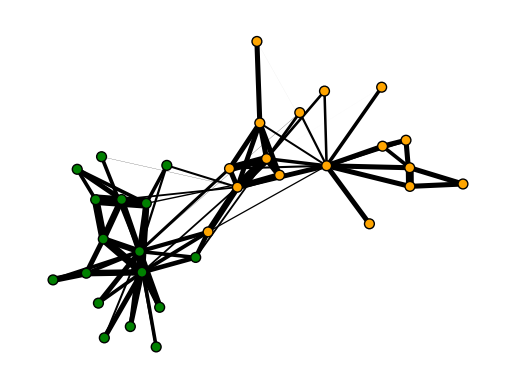

In [2]:
from gradnet import GradNet
from gradnet.trainer import fit
from gradnet.utils import plot_graph
import torch
from matplotlib import pyplot as plt
import networkx as nx
from gradnet.ode import integrate_ode


net = nx.karate_club_graph()  # Load Zachary's Karate Club graph
adj0 = nx.to_numpy_array(net)  # Get adjacency matrix as a NumPy array
mask = (adj0 > 0).astype(float)  # mask every non-existant edge

N = len(net)
budget = 100  # let's give it a large amount of budget and not force to use it all

gn = GradNet(num_nodes=N, adj0=adj0, mask = mask, delta_sign="free", final_sign="nonnegative",
            budget=budget, rand_init_weights=False, use_budget_up=False)


def do_dt(t, o, A):
    L = torch.diag(A.sum(dim=1)) - A
    do = - L@o
    do[0] = 0
    do[-1] = 0
    return do

def dissonans(adj, o):
    o_dif = (o.unsqueeze(-1)-o.unsqueeze(-2))**2
    return (adj*o_dif).sum()/adj.sum()

def loss_fn(gn):
    adj = gn()

    tt = torch.linspace(0, 15, 150)  # time grid to evaluate the numerical solutions
    o0 = torch.zeros(N)  # set the initial opinions to 0
    o0[0] = 1  # administrator
    o0[-1] = -1  # instructor

    tt, oo = integrate_ode(adj, f=do_dt, x0=o0, tt=tt)  # integrate the ODE
    o = oo[-1]
    
    return dissonans(adj, oo), {"used_b": gn.get_delta_adj().sum().item()}  #compute dissonance


fit(gn=gn, loss_fn=loss_fn, num_updates=100, optim_kwargs={"lr": 0.1}, accelerator="cpu")

# Plot the results
col = ['orange' if net.nodes[nd]['club']== 'Mr. Hi' else 'green' for nd in range(N)]

plot_graph(gn, node_size=50, draw_kwargs={"node_color": col})

In [ ]:
gn.get_delta_adj()